In [1]:
import sys
sys.path.append('../snow_scaling/')

import numpy as np

import rasterio
import rasterio.mask

from shapely.geometry import Point

import matplotlib.pyplot as plt

from sampling import circle
from filepath import TUOLUMNE_TIFFS

import skgstat as skg

tuolumne_tiffs = list(TUOLUMNE_TIFFS)

## Get a test dataset
_The first tif is corrupt!_

In [2]:
test_scene = tuolumne_tiffs[1]

ds = rasterio.open(test_scene)
snow_depth = ds.read(1, masked=True)

## Define test region to calculate variogram
I define a single circle in the center of the image for testing the workflow

In [3]:
x0 = np.mean([ds.bounds.left, ds.bounds.right])
y0 = np.mean([ds.bounds.bottom, ds.bounds.top])
circle_mask = circle(x0, y0, radius=500)

Plot the data and the test region

In [4]:
snow_depth.max()

24.60337

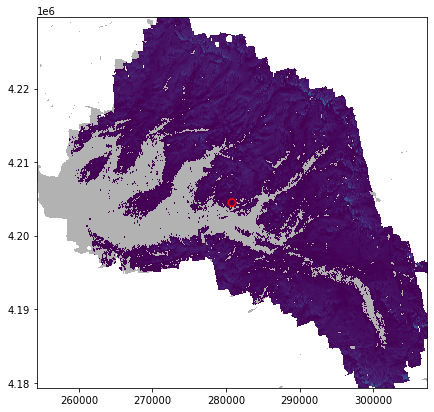

In [5]:
from matplotlib import cm

viridis = cm.get_cmap('viridis', 256)
viridis.set_under('0.7')

x, y = circle_mask.exterior.coords.xy

fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(snow_depth, origin='upper', 
          extent=[ds.bounds.left, ds.bounds.right, ds.bounds.bottom, ds.bounds.top],
          vmin=0.001, cmap=viridis)
ax.plot(x, y, 'r-')

## Subset `snow_depth` within `circle_mask`

In [6]:
region, region_transform = rasterio.mask.mask(ds, [circle_mask], crop=True)
region = np.squeeze(region)  # drop axis with size=1
region = np.where(region <= ds.nodata, np.nan, region)

# Get extent of image
x0, y0 = region_transform * (0,0)
x1, y1 = region_transform * region.shape
extent = [x0, x1, y0, y1]  # Use namedtuple

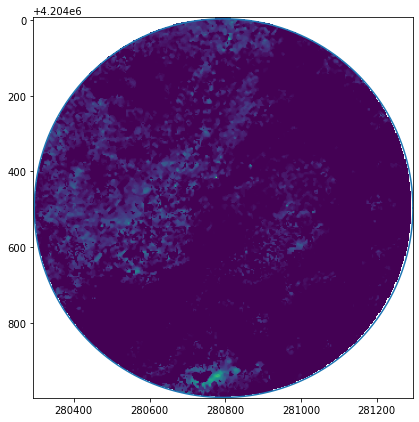

In [7]:
fig, ax = plt.subplots(figsize=(7.,7.))
ax.imshow(region, origin='upper', extent=extent)
ax.plot(x, y)

## Sampling within the region
There are a number of possible approaches.
1. Over sample points for a region defined by the bounds of the Polygon and then check for points within the polygon.  
2. For a circular region we can use polar coordinates.  

In [8]:
def get_sample_points(subregion, nsamples=10000, transform=None):
    '''Returns a sample points for a given region'''
    
    _nsamples = int(nsamples * 4 / np.pi)  # Adjust number of points to account for circular region
    
    nrow, ncol = region.shape
    x = np.random.randint(0, nrow, _nsamples)
    y = np.random.randint(0, ncol, _nsamples)

    sample = subregion[x, y]
    
    # Return only valid cells
    valid = np.nonzero(np.isfinite(sample))[0]
    x = x[valid]
    y = y[valid]
    sample = sample[valid]
    
    if transform:
        sample_points = [transform * (xp, yp) for xp, yp in zip(x, y)]

    return sample, sample_points


In [9]:
sample, sample_points = get_sample_points(region, transform=region_transform)
#print(f'{valid.shape[0]} out of {sample.shape[0]} within circle')

In [10]:
sample.shape

(10011,)

Text(0.5, 1.0, 'npoints = 10011')

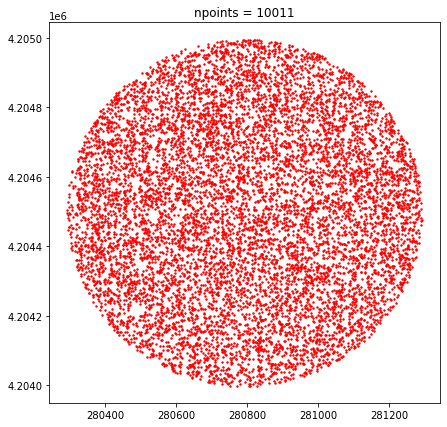

In [11]:
x, y = zip(*sample_points)

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(x, y, 2, c='r')
ax.set_title(f'npoints = {len(sample_points)}')

Second way

In [12]:
def get_sample_points_geom(circle_mask, nsamples = 10000):
    
    np.random.seed(42)
    
    x0, y0, x1, y1 = circle_mask.bounds
    
    sample_points = []
    while len(sample_points) < nsamples:
        x = np.random.uniform(x0, x1)
        y = np.random.uniform(y0, y1)
        if circle_mask.contains(Point(x, y)):
            sample_points.append((x, y))

    return sample_points

Text(0.5, 1.0, 'npoints = 10011')

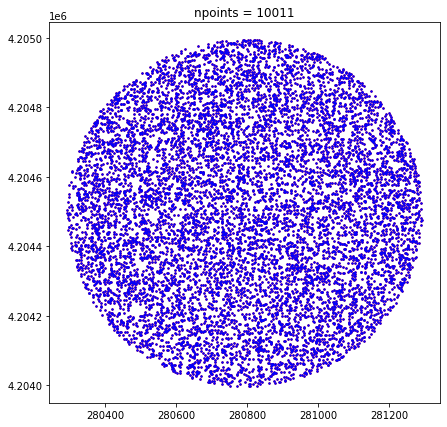

In [13]:
sample_points_geo = get_sample_points_geom(circle_mask)

xg, yg = zip(*sample_points)
x, y = zip(*sample_points)

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(x, y, 2, c='r')
ax.scatter(xg, yg, 2, c='b')

ax.set_title(f'npoints = {len(sample_points)}')

### Get all points within circle

In [14]:
xi, yj = np.isfinite(region).nonzero()
sample_all = region[xi, yj]
sample_points_all = np.array([region_transform * (i, j) for i, j in zip(xi, yj)])
sample_all.shape, sample_points_all.shape

((87286,), (87286, 2))

## Calculate a test variogram
I use `scikit-gstat` for this.  For starters, I'll run an omni-directional variogram

In [16]:
bins = np.logspace(np.log10(3), np.log10(1000), 100)
V_log = skg.Variogram(sample_points_all, sample_all, bin_func=bins, samples=10000)

In [18]:
V_even = skg.Variogram(sample_points_all, sample_all, n_lags=100, maxlag=1000, bin_func='even', samples=10000)

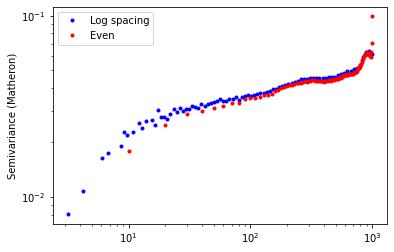

In [19]:
fig, ax = plt.subplots()

ax.plot(V_log.bins, V_log.experimental, '.b', label='Log spacing')
ax.plot(V_even.bins, V_even.experimental, '.r', label='Even')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Semivariance (Matheron)');

ax.legend()

In [20]:
distance = V_log.triangular_distance_matrix
distance = distance[distance != 0]

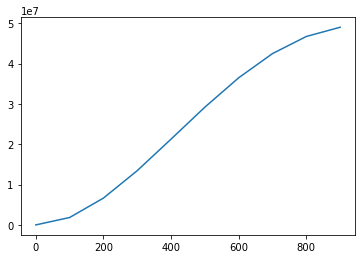

In [25]:
lag = np.arange(0, 1000, 100)
count = [np.count_nonzero(distance < thislag) for thislag in lag]
plt.plot(lag, count)

In [28]:
from scipy.spatial.distance import pdist

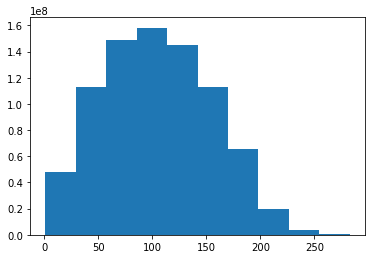

In [45]:
n_points = 200
x, y = np.meshgrid(np.arange(n_points+1), np.arange(n_points+1))
points = [(xx, yy) for xx, yy in zip(x.flatten(), y.flatten())]
#points = [(x, y) for x, y in zip(np.arange(n_points+1), np.arange(n_points+1))]
plt.hist(pdist(points));

In [21]:
for i, (lbin, lclass) in enumerate(zip(V_log.bins, V_log.lag_classes())):
    print(f'{i} {lbin} {len(lclass)}')

0 3.0 0
1 3.181301852808627 2299
2 3.3735604928945344 0
3 3.577438082202456 0
4 3.7936367997396045 0
5 4.022901259964865 0
6 4.2660210773307945 2287
7 4.523833585811037 0
8 4.7972267227795165 0
9 5.087142087173842 0
10 5.394578182475632 0
11 5.720593855676907 0
12 6.0663119440768645 2207
13 6.432923142468944 0
14 6.821690104037315 4618
15 7.23395178908673 0
16 7.6711280765832965 0
17 8.134724654388908 0
18 8.626338205031814 2327
19 9.147661904873855 2200
20 9.700491255614027 4454
21 10.286730268212931 0
22 10.90839802053613 4535
23 11.567635611301846 0
24 12.266713534283209 2192
25 13.008039498162608 6840
26 13.794166718970839 4607
27 14.627802713671004 0
28 15.511818625173547 11327
29 16.449259110898662 4569
30 17.443352828943695 2299
31 18.497523557971064 11281
32 19.61540198911485 8907
33 20.80083823051904 4481
34 22.057915067574243 17945
35 23.39096202452309 4454
36 24.804570275863842 20023
37 26.30360845890915 11095
38 27.893239441960123 19781
39 29.578938105847463 13225
40 31.366

In [20]:
V?

Type:           Variogram
String form:   
spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   48.33
Sill:              0.04
Nugget:            0.00
        
File:           ~/anaconda3/envs/snow_scaling/lib/python3.8/site-packages/skgstat/Variogram.py
Docstring:     
Variogram Class

Calculates a variogram of the separating distances in the given
coordinates and relates them to one of the semi-variance measures of
the given dependent values.
Init docstring:
Variogram Class

Parameters
----------
coordinates : numpy.ndarray, MetricSpace
    .. versionchanged:: 0.5.0
        now accepts MetricSpace
    Array of shape (m, n). Will be used as m observation points of
    n-dimensions. This variogram can be calculated on 1 - n
    dimensional coordinates. In case a 1-dimensional array is passed,
    a second array of same length containing only zeros will be
    stacked to the passed one.
    For very large datasets, you can set maxlag to only calculate
   

In [ ]:
skg.Variogram.set_dist_function?

### Directional Variogram

In [ ]:
V = skg.DirectionalVariogram(sample_points, sample, azimuth=12.5, tolerance=6.25, n_lags=100, maxlag=1000)

In [ ]:
fig, ax = plt.subplots()
ax.plot(V.bins, V.experimental, '.b')
ax.set_ylabel('Semivariance (Matheron)');